In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import random
import numpy

<IPython.core.display.Javascript object>

In [3]:
def flip():
    return 1 if random.random() < 0.5 else 0


def generate():
    return random.triangular(0, 1, 1)


def prepare_for_XGBoost(X, y):
    return xgb.DMatrix(X, label=y)


def predict_with_XGBoost(model, dX, y):
    temp = model.predict(dX)
    return [round(x) for x in temp]


from sklearn.metrics import confusion_matrix


def predict_with_XGBoost_and_return_confusion_matrix(model, dX, y):
    temp = model.predict(dX)
    temp = [round(x) for x in temp]
    return confusion_matrix(y, temp)

<IPython.core.display.Javascript object>

(array([ 455., 1486., 2479., 3546., 4479., 5543., 6595., 7514., 8359.,
        9544.,    0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1]),
 <a list of 11 Patch objects>)

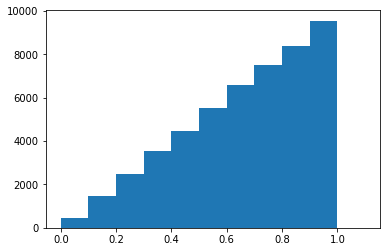

<IPython.core.display.Javascript object>

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
bins = [0.1 * i for i in range(12)]
plt.hist([random.triangular(0, 1, 1) for i in range(50000)], bins)

In [5]:
# m = 1000000
m = 10000
benign_features = 5
malicious_features = 5
n = benign_features + malicious_features
benign = 0
malicious = 1
X = numpy.zeros((m, n))
y = numpy.zeros((m))
for i in range(m):
    vec = numpy.zeros((n))
    y[i] = flip()
    if y[i] == benign:
        for j in range(benign_features):
            vec[j] = generate()
        for j in range(malicious_features):
            vec[j + benign_features] = 1 - generate()
    else:
        for j in range(benign_features):
            vec[j] = 1 - generate()
        for j in range(malicious_features):
            vec[j + benign_features] = generate()
    X[i, :] = vec

<IPython.core.display.Javascript object>

In [6]:
print(X[:5])
print(y[:5])

[[5.61461852e-01 2.76991789e-01 9.24858589e-04 2.43625088e-01
  5.67018766e-01 9.28469660e-01 9.97591257e-01 3.28952400e-01
  6.05040053e-01 6.93348768e-01]
 [4.50636705e-01 7.45103877e-01 2.81403751e-01 1.62180281e-01
  2.25516880e-01 5.98855436e-01 1.51865599e-01 2.90491480e-02
  3.97418923e-02 8.20131220e-02]
 [1.80468576e-01 1.77564283e-01 3.33366310e-03 3.29115047e-01
  5.66780794e-01 5.63564722e-01 9.46708554e-01 4.49821288e-01
  9.69483314e-01 7.91461712e-01]
 [4.41344671e-02 3.00705154e-01 3.91129874e-02 1.71168166e-02
  3.22896751e-01 7.19984055e-01 9.74147384e-01 6.78770686e-01
  7.99997396e-01 4.87811167e-01]
 [6.61709824e-02 1.90439819e-01 5.39713196e-02 7.87636748e-01
  1.70595366e-01 9.45041839e-01 9.58256660e-01 7.03288934e-01
  3.28839386e-01 6.94745862e-01]]
[1. 0. 1. 1. 1.]


<IPython.core.display.Javascript object>

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

In [8]:
import xgboost as xgb

dtrain = prepare_for_XGBoost(X_train, y_train)
dtest = prepare_for_XGBoost(X_test, y_test)
dall = prepare_for_XGBoost(X, y)

<IPython.core.display.Javascript object>

In [9]:
params = {
    "n_jobs": -1,
}
model_no_constraints = xgb.train(params=params, dtrain=dtrain)
print("Unconstrained model's training confusion matrix:")
print(
    predict_with_XGBoost_and_return_confusion_matrix(
        model_no_constraints, dtrain, y_train
    )
)
print()
print("Unconstrained model's testing confusion matrix:")
print(
    predict_with_XGBoost_and_return_confusion_matrix(
        model_no_constraints, dtest, y_test
    )
)
model_no_constraints = xgb.train(params=params, dtrain=dall)

Unconstrained model's training confusion matrix:
[[3888   25]
 [  21 4066]]

Unconstrained model's testing confusion matrix:
[[981  29]
 [ 30 960]]


<IPython.core.display.Javascript object>

In [16]:
params_constrained = params.copy()
monotone_constraints = (
    "("
    + ",".join([str(0) for m in range(benign_features)])
    + ","
    + ",".join([str(1) for m in range(malicious_features)])
    + ")"
)
print("Monotone constraints enforced are:")
print(monotone_constraints)
params_constrained["monotone_constraints"] = monotone_constraints
model_monotonic = xgb.train(params=params_constrained, dtrain=dtrain)
print("Monotonic model's training confusion matrix:")
print(
    predict_with_XGBoost_and_return_confusion_matrix(model_monotonic, dtrain, y_train)
)
print()
print("Monotonic model's testing confusion matrix:")
print(predict_with_XGBoost_and_return_confusion_matrix(model_monotonic, dtest, y_test))
model_monotonic = xgb.train(params=params_constrained, dtrain=dall)

Monotone constraints enforced are:
(0,0,0,0,0,1,1,1,1,1)
Monotonic model's training confusion matrix:
[[3877   36]
 [  39 4048]]

Monotonic model's testing confusion matrix:
[[993  17]
 [ 22 968]]


<IPython.core.display.Javascript object>

In [11]:
X_malicious = X[y == malicious]
y_malicious = len(X_malicious) * [malicious]
dX_malicious = prepare_for_XGBoost(X_malicious, y_malicious)
print("Unconstrained model's confusion matrix on malicious dataset:")
print(
    predict_with_XGBoost_and_return_confusion_matrix(
        model_no_constraints, dX_malicious, y_malicious
    )
)
print("Monotonic model's confusion matrix on malicious dataset:")
print(
    predict_with_XGBoost_and_return_confusion_matrix(
        model_monotonic, dX_malicious, y_malicious
    )
)

Unconstrained model's confusion matrix on malicious dataset:
[[   0    0]
 [  32 5045]]
Monotonic model's confusion matrix on malicious dataset:
[[   0    0]
 [  53 5024]]


<IPython.core.display.Javascript object>

In [12]:
X_adversarial = X_malicious
y_adversarial = len(X_adversarial) * [malicious]
for i in range(len(X_adversarial)):
    vec = X_adversarial[i, :]
    for j in range(benign_features):
        vec[j] = 1
    X_adversarial[i, :] = vec

<IPython.core.display.Javascript object>

In [13]:
data = X_adversarial
label = y_adversarial
dadv = xgb.DMatrix(data, label=label)

<IPython.core.display.Javascript object>

In [14]:
print("Unconstrained model's confusion matrix on adversarial dataset:")
predict_with_XGBoost_and_return_confusion_matrix(
    model_no_constraints, dadv, y_adversarial
)

Unconstrained model's confusion matrix on adversarial dataset:


array([[   0,    0],
       [5066,   11]], dtype=int64)

<IPython.core.display.Javascript object>

In [15]:
print("Monotonic model's confusion matrix on adversarial dataset:")
predict_with_XGBoost_and_return_confusion_matrix(model_monotonic, dadv, y_adversarial)

Monotonic model's confusion matrix on adversarial dataset:


array([[   0,    0],
       [4222,  855]], dtype=int64)

<IPython.core.display.Javascript object>